In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import wfdb

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout,Conv1D, MaxPooling1D, GlobalAveragePooling1D
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, roc_curve, auc
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")



2024-05-19 22:37:37.867120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 22:37:37.867216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 22:37:38.020640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Importing Data

In [2]:
os.chdir("/kaggle/input/mit-bih")

# Extracting file names without extension
directory = os.listdir()
directory = [x.split('.')[0] for x in directory]
directory.remove('102-0') 
directory.remove('RECORDS')
directory.remove('SHA256SUMS')
directory.remove('ANNOTATORS')
directory = set(directory)
directory = list(directory)

# Data Visualization

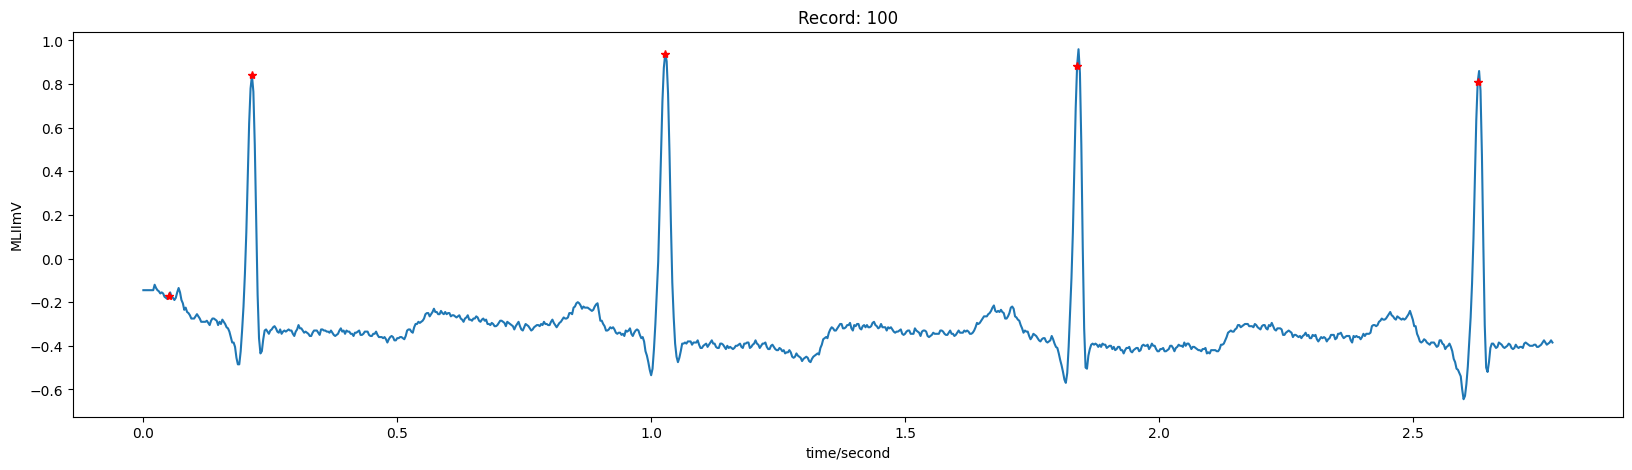

In [3]:
record = wfdb.rdrecord('100' , sampto=1000   ,channels=[0])

ann = wfdb.rdann('100' , 'atr' , sampto=1000)

wfdb.plot_wfdb(record , annotation=ann ,figsize=(20 , 5))

In [37]:
#print(record.__dict__)

In [5]:
print(ann.__dict__)

{'record_name': '100', 'extension': 'atr', 'sample': array([ 18,  77, 370, 662, 946]), 'symbol': ['+', 'N', 'N', 'N', 'N'], 'subtype': array([0, 0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0]), 'num': array([0, 0, 0, 0, 0]), 'aux_note': ['(N\x00', '', '', '', ''], 'fs': 360, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels': None, 'ann_len': 5}


In [6]:
record = wfdb.rdrecord('100'  ,channels=[0])
print(len(record.__dict__['p_signal']))

650000


# Data Preprocessing

In [7]:
def extract_beats_and_labels(sig_directory):
    window_size = 256
    Full_Signal = wfdb.rdrecord(sig_directory ,sampto=650000   ,channels=[0] )
    Full_Signal =  Full_Signal.__dict__['p_signal'].flatten()
    ann    = wfdb.rdann(sig_directory ,'atr' , sampto=650000 )
    ann_pos =ann.__dict__['sample'][1:-1]
    ann_sym =ann.__dict__['symbol'][1:-1]
    
    data_Full = []
    data_Sym = []
    for QRS_pos ,Beat_diagnose in zip(ann_pos , ann_sym):
        start  = QRS_pos-window_size//2
        end  = QRS_pos + window_size // 2
        signal_corpus= Full_Signal[start:end]
        if len(signal_corpus) ==256 :
            
            data_Full.append(list(signal_corpus))
            data_Sym.append(Beat_diagnose)
    return data_Full , data_Sym 

In [8]:
# Extracting beats and labels for all signals in the directory
X = []
Y = []
for sig_name in directory:
    Full_Signal, annotation_symbol = extract_beats_and_labels(sig_name)
    X.extend(Full_Signal)
    Y.extend(annotation_symbol)
X = np.array(X)
Y = np.array(Y)

In [9]:
print(X)

[[ 0.24   0.265  0.26  ... -0.12  -0.105 -0.105]
 [ 0.205  0.19   0.22  ... -0.21  -0.2   -0.2  ]
 [ 0.215  0.205  0.18  ... -0.195 -0.195 -0.19 ]
 ...
 [-0.345 -0.365 -0.365 ... -0.135 -0.13  -0.13 ]
 [-0.075 -0.07  -0.075 ... -0.05  -0.055 -0.075]
 [-0.075 -0.06  -0.055 ... -0.095 -0.07  -0.075]]


In [10]:
print(Y)

['N' 'N' 'N' ... 'L' 'L' 'L']


In [11]:
print(set(Y))

{'A', '"', 'E', 'j', '~', 'N', 'F', 'a', 'e', 'x', '!', ']', 'J', 'L', '|', '/', '[', '+', 'f', 'Q', 'V', 'S', 'R'}


In [12]:
Normal_mask = Y == 'N'
abnormal_mask = Y != 'N'
Normal_data = X[Normal_mask]
abnormal_data = X[abnormal_mask]

df_n = pd.DataFrame(Normal_data)
df_n["L"] = "N"
df_abn = pd.DataFrame(abnormal_data)
df_abn["L"] = "ABN"

df = pd.concat([df_n, df_abn], ignore_index=True)

In [13]:
print(df)

            0      1      2      3      4      5      6      7      8      9  \
0       0.240  0.265  0.260  0.265  0.250  0.245  0.255  0.265  0.265  0.245   
1       0.205  0.190  0.220  0.250  0.250  0.210  0.195  0.175  0.185  0.210   
2       0.215  0.205  0.180  0.160  0.140  0.130  0.135  0.125  0.105  0.075   
3       0.150  0.145  0.135  0.120  0.100  0.095  0.095  0.090  0.075  0.040   
4       0.175  0.175  0.165  0.160  0.175  0.190  0.180  0.170  0.135  0.095   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
112524 -0.265 -0.270 -0.290 -0.290 -0.280 -0.255 -0.270 -0.300 -0.295 -0.300   
112525 -0.270 -0.255 -0.265 -0.270 -0.275 -0.305 -0.290 -0.280 -0.270 -0.280   
112526 -0.345 -0.365 -0.365 -0.345 -0.350 -0.340 -0.350 -0.370 -0.375 -0.365   
112527 -0.075 -0.070 -0.075 -0.080 -0.090 -0.100 -0.090 -0.075 -0.070 -0.080   
112528 -0.075 -0.060 -0.055 -0.065 -0.080 -0.090 -0.090 -0.075 -0.070 -0.065   

        ...    247    248    249    250

In [14]:
print(df["L"].value_counts())

L
N      75003
ABN    37526
Name: count, dtype: int64


<Axes: xlabel='L'>

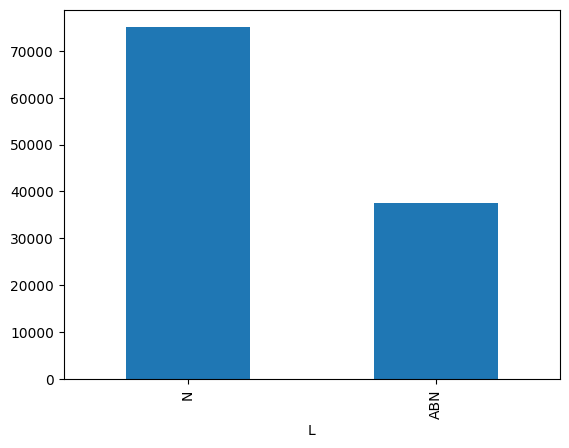

In [15]:
df["L"].value_counts().plot(kind="bar")

In [16]:
label_dictionary = {"N": 0, "ABN": 1}

In [17]:
df["L"] = df["L"].map(label_dictionary)

X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

In [18]:
sampling_strategy = {0: 37000, 1: 37000}  

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=30)

X_resampled, y_resampled = rus.fit_resample(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.8, random_state=30)



In [19]:
print(X_resampled.shape)
print(y_resampled.shape)
print("*"*20)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(74000, 256)
(74000,)
********************
(59200, 256)
(14800, 256)
(59200,)
(14800,)


# Evaluation Metrices

In [20]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
    # Confusion matrix for training set
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    # Confusion matrix for testing set
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    # Plotting the confusion matrix for training set
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Training Set')
    plt.show()
    # Plotting the confusion matrix for testing set
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Testing Set')
    plt.show()
    # Classification report for training set
    print('Classification Report - Training Set')
    print(classification_report(y_train, y_train_pred))
    # Classification report for testing set
    print('Classification Report - Testing Set')
    print(classification_report(y_test, y_test_pred))
    


In [21]:
# Function to plot loss curves and ROC curves
def plot_curves(history, model, X_train, y_train, X_test, y_test):
    # Plotting the training and testing loss curves
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()

    # ROC curve for training set
    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train))
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Training Set')
    plt.legend(loc="lower right")
    plt.show()

    # ROC curve for testing set
    fpr_test, tpr_test, _ = roc_curve(y_test, model.predict(X_test))
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Testing Set')
    plt.legend(loc="lower right")
    plt.show()


# Training Model - DNN(Deep Neural Network)

In [22]:
DNN_model = Sequential()
DNN_model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
DNN_model.add(Dropout(rate = 0.25))
DNN_model.add(Dense(1, activation = 'sigmoid'))
DNN_model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [23]:
DNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,257 (32.25 KB)

 Trainable params: 8,257 (32.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history=DNN_model.fit(X_train, y_train, batch_size = 32, epochs= 10,validation_data=(X_test , y_test))
history

Epoch 1/10
 101/1850 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6795 - loss: 0.5844

I0000 00:00:1716158343.868597     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1850/1850 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8562 - loss: 0.3496 - val_accuracy: 0.9376 - val_loss: 0.1853
Epoch 2/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9355 - loss: 0.1995 - val_accuracy: 0.9502 - val_loss: 0.1552
Epoch 3/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9430 - loss: 0.1790 - val_accuracy: 0.9568 - val_loss: 0.1379
Epoch 4/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9492 - loss: 0.1627 - val_accuracy: 0.9607 - val_loss: 0.1303
Epoch 5/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9519 - loss: 0.1591 - val_accuracy: 0.9632 - val_loss: 0.1253
Epoch 6/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9541 - loss: 0.1526 - val_accuracy: 0.9606 - val_loss: 0.1219
Epoch 7/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9545 - loss: 0.1482 - val_accuracy: 0.9666 - val_loss: 0.1208
Epoch 8/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9561 - loss: 0.1456 - val_accurac

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


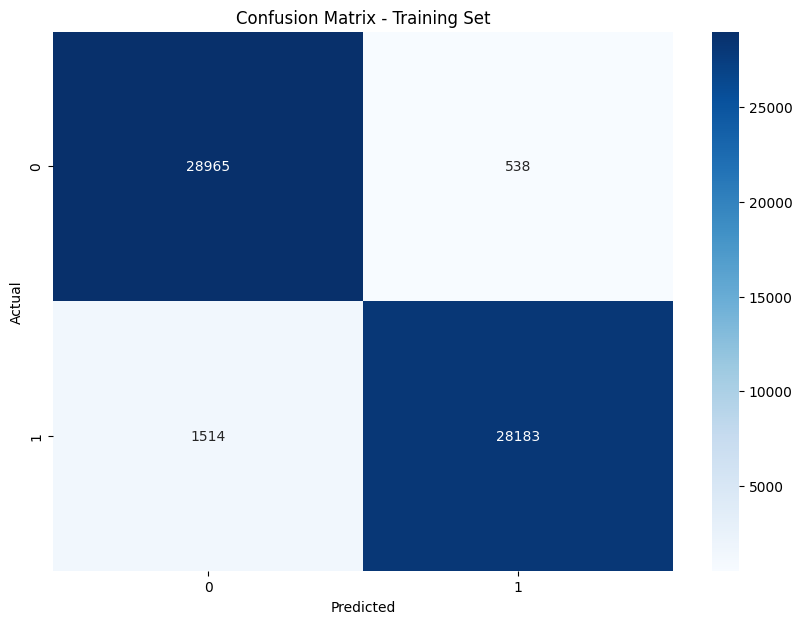

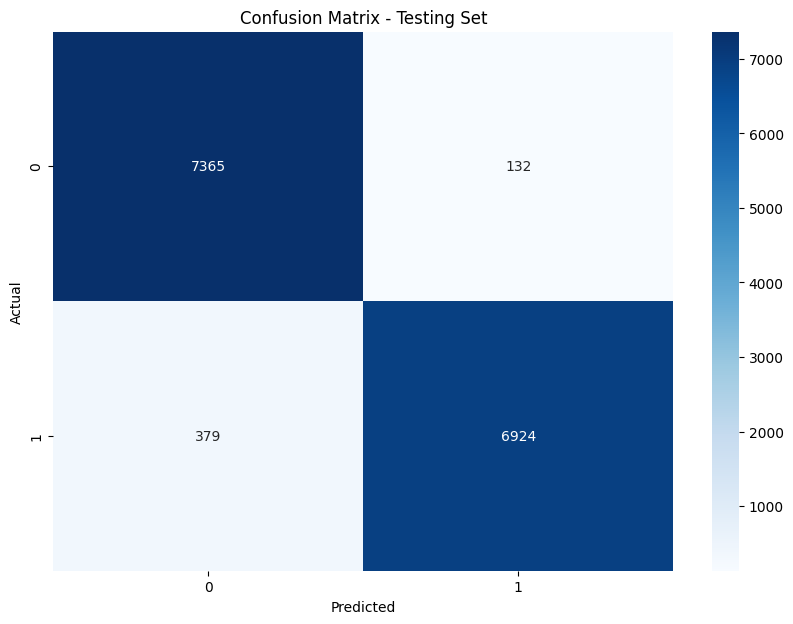

Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     29503
           1       0.98      0.95      0.96     29697

    accuracy                           0.97     59200
   macro avg       0.97      0.97      0.97     59200
weighted avg       0.97      0.97      0.97     59200

Classification Report - Testing Set
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7497
           1       0.98      0.95      0.96      7303

    accuracy                           0.97     14800
   macro avg       0.97      0.97      0.97     14800
weighted avg       0.97      0.97      0.97     14800



In [25]:
evaluate_model(DNN_model, X_train, y_train, X_test, y_test)

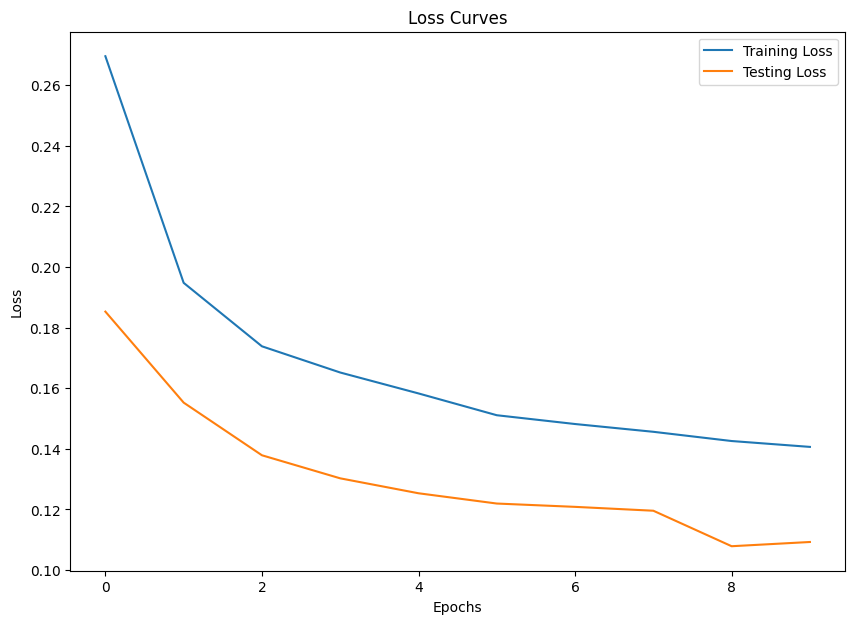

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


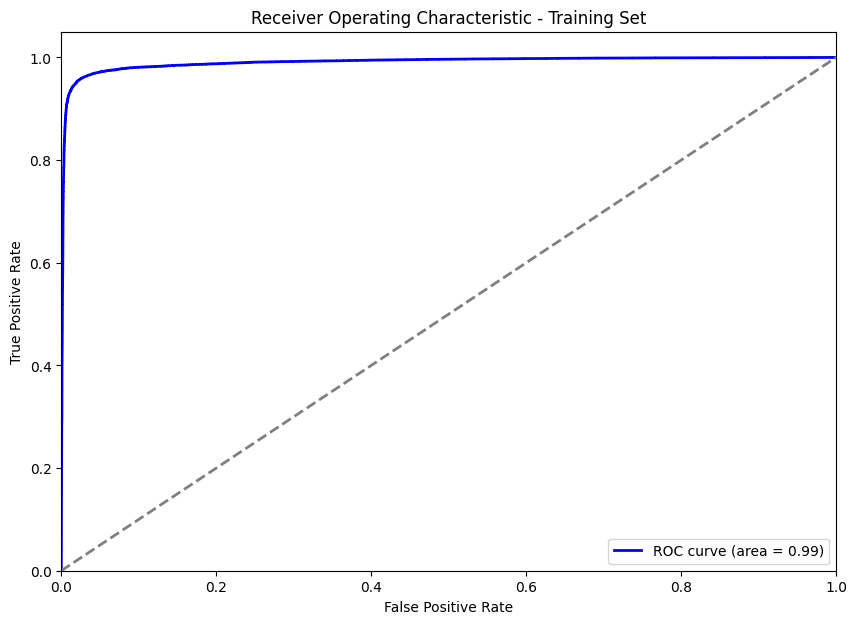

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


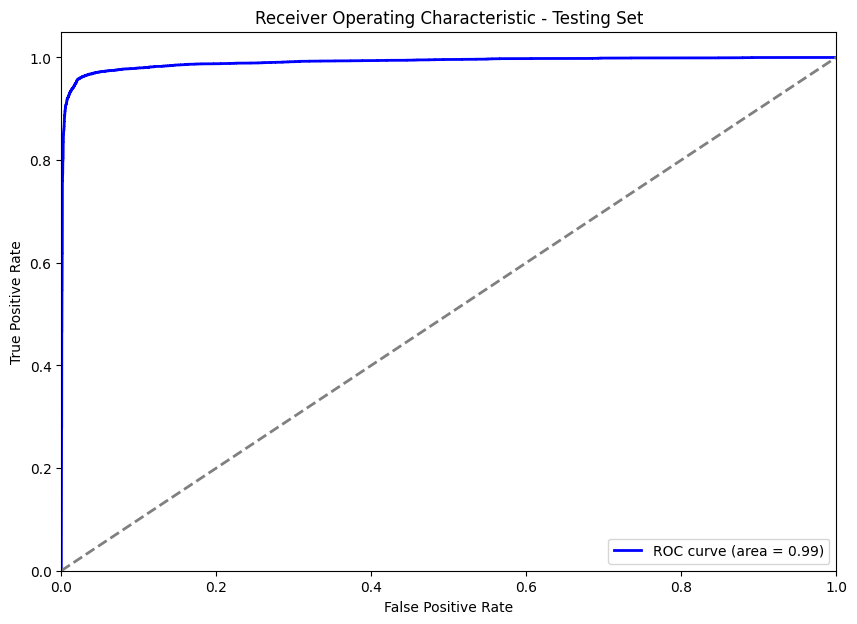

In [26]:
plot_curves(history, DNN_model, X_train, y_train, X_test, y_test)

# Training Model - CNN

In [28]:
CNN_model = Sequential()
CNN_model.add(Conv1D(256, 7, activation='relu', input_shape=(256, 1) ,padding='same' ) )
CNN_model.add(MaxPooling1D(5))
CNN_model.add(Dropout(.2))
CNN_model.add(Conv1D(128, 5,padding='same' ,activation='relu'))
CNN_model.add(MaxPooling1D(5))
CNN_model.add(Conv1D(64, 5,padding='same' ,activation='relu'))
CNN_model.add(MaxPooling1D(5))
CNN_model.add(GlobalAveragePooling1D())
CNN_model.add(Dense(50 , activation='relu'))
CNN_model.add(Dense(10 , activation='relu'))
CNN_model.add(Dense(1 , activation='sigmoid'))
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
CNN_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 256, 256)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 51, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 51, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 51, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,811 (823.48 KB)

 Trainable params: 210,811 (823.48 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history=CNN_model.fit(x = X_train , y = y_train , batch_size= 32 , epochs = 10 ,validation_data=(X_test , y_test))
history

Epoch 1/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8850 - loss: 0.2604 - val_accuracy: 0.9639 - val_loss: 0.1049
Epoch 2/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9698 - loss: 0.0921 - val_accuracy: 0.9758 - val_loss: 0.0706
Epoch 3/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9751 - loss: 0.0734 - val_accuracy: 0.9582 - val_loss: 0.1170
Epoch 4/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9796 - loss: 0.0602 - val_accuracy: 0.9801 - val_loss: 0.0558
Epoch 5/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9810 - loss: 0.0550 - val_accuracy: 0.9864 - val_loss: 0.0432
Epoch 6/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9830 - loss: 0.0505 - val_accuracy: 0.9856 - val_loss: 0.0439
Epoch 7/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9837 - loss: 0.0451 - val_accuracy: 0.9834 - val_loss: 0.0511
Epoch 8/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9839 - loss: 0.0447 -

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


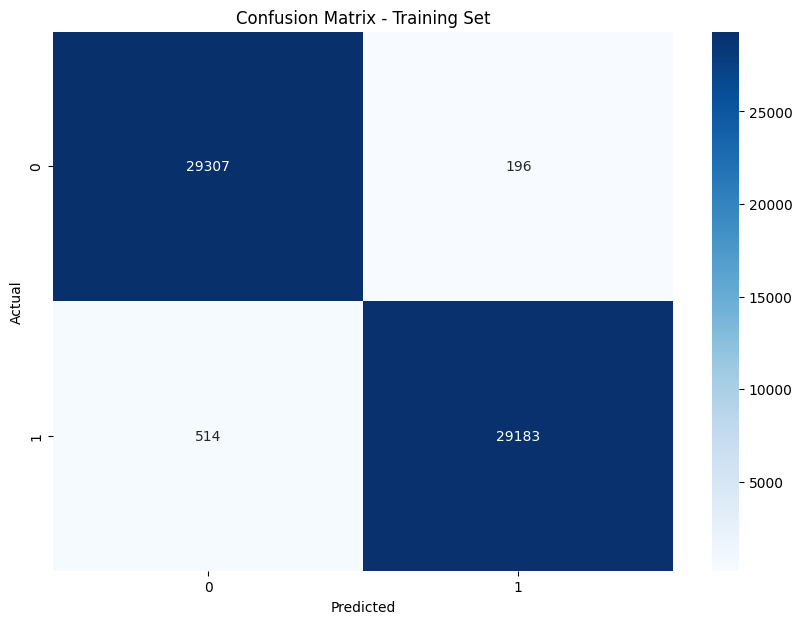

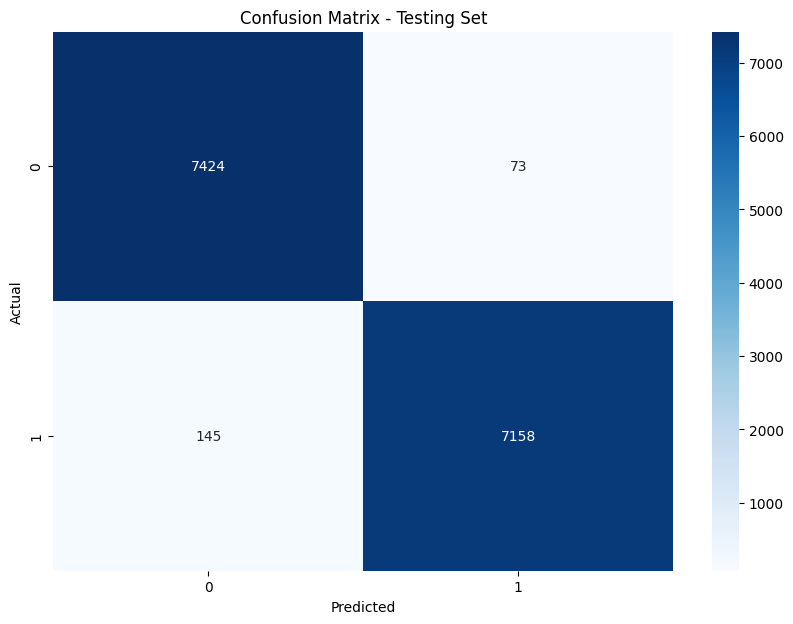

Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     29503
           1       0.99      0.98      0.99     29697

    accuracy                           0.99     59200
   macro avg       0.99      0.99      0.99     59200
weighted avg       0.99      0.99      0.99     59200

Classification Report - Testing Set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7497
           1       0.99      0.98      0.99      7303

    accuracy                           0.99     14800
   macro avg       0.99      0.99      0.99     14800
weighted avg       0.99      0.99      0.99     14800



In [31]:
evaluate_model(CNN_model, X_train, y_train, X_test, y_test)

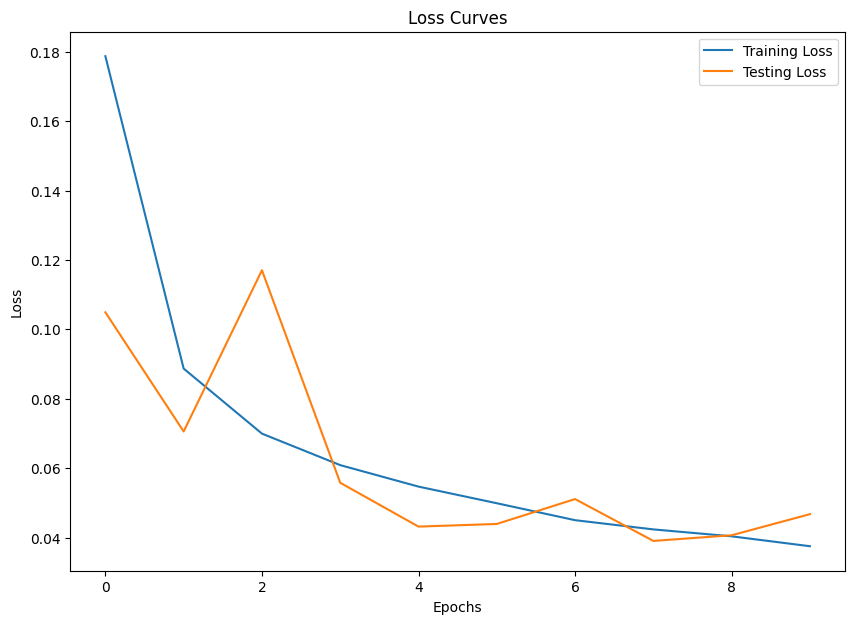

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


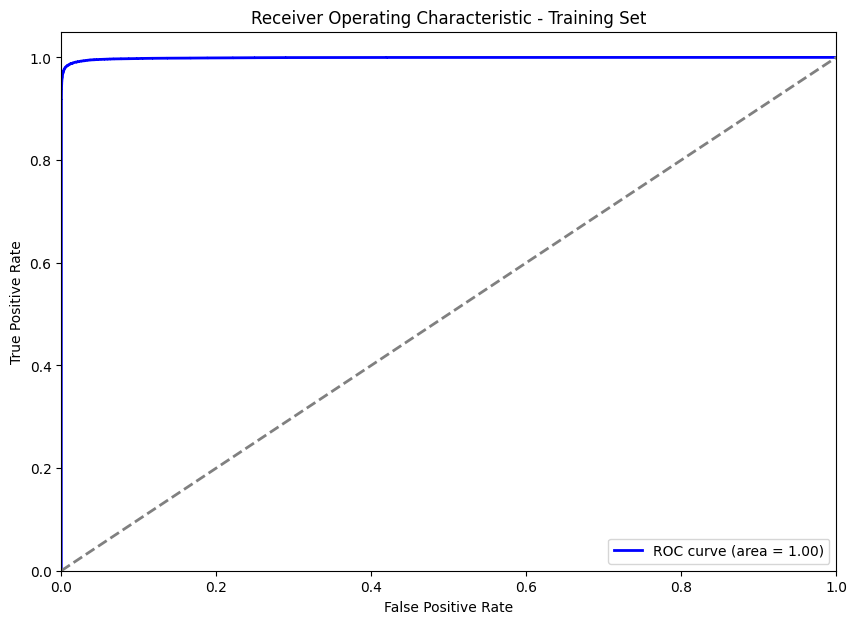

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


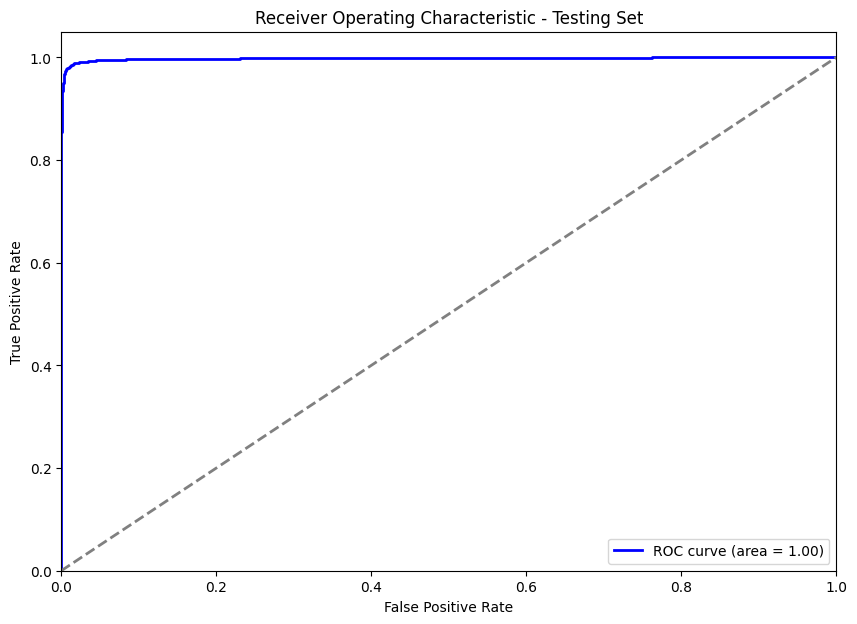

In [32]:
plot_curves(history, CNN_model, X_train, y_train, X_test, y_test)

# Training Model - XGBoost

In [33]:
#the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
history=xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Train Accuracy",train_accuracy)
print("Test Accuracy:",test_accuracy)

Train Accuracy 0.9985472972972973
Test Accuracy: 0.9812162162162162


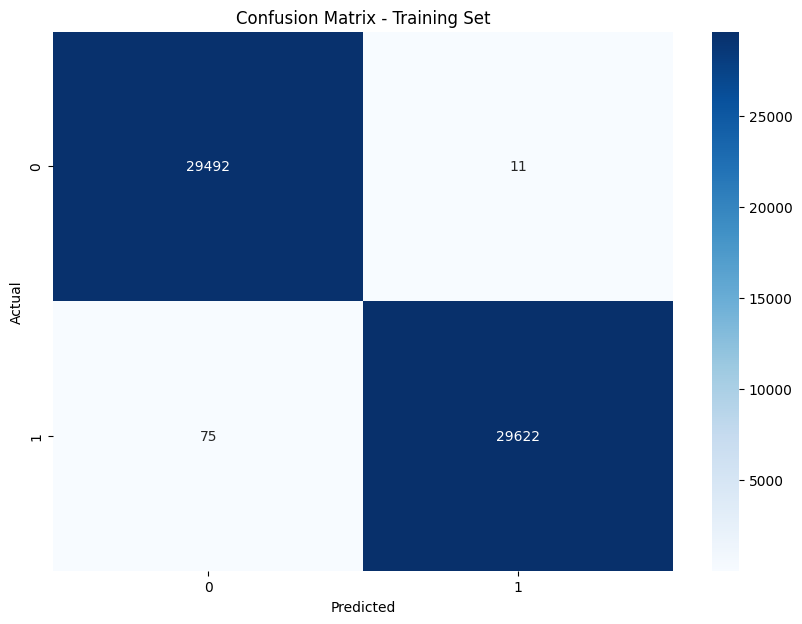

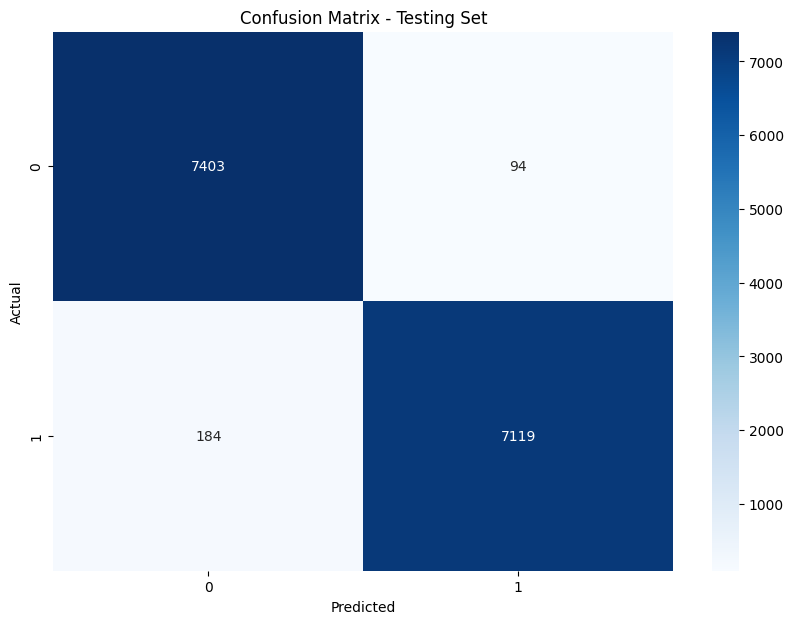

Classification Report - Training Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29503
           1       1.00      1.00      1.00     29697

    accuracy                           1.00     59200
   macro avg       1.00      1.00      1.00     59200
weighted avg       1.00      1.00      1.00     59200

Classification Report - Testing Set
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7497
           1       0.99      0.97      0.98      7303

    accuracy                           0.98     14800
   macro avg       0.98      0.98      0.98     14800
weighted avg       0.98      0.98      0.98     14800



In [34]:
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

# Training Model - Decision Tree

In [35]:
DT_model = DecisionTreeClassifier(random_state=30)

# Train the model
history=DT_model.fit(X_train, y_train)

# Make predictions on the test set
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Train Accuracy",train_accuracy)
print("Test Accuracy:",test_accuracy)

Train Accuracy 1.0
Test Accuracy: 0.9556756756756757


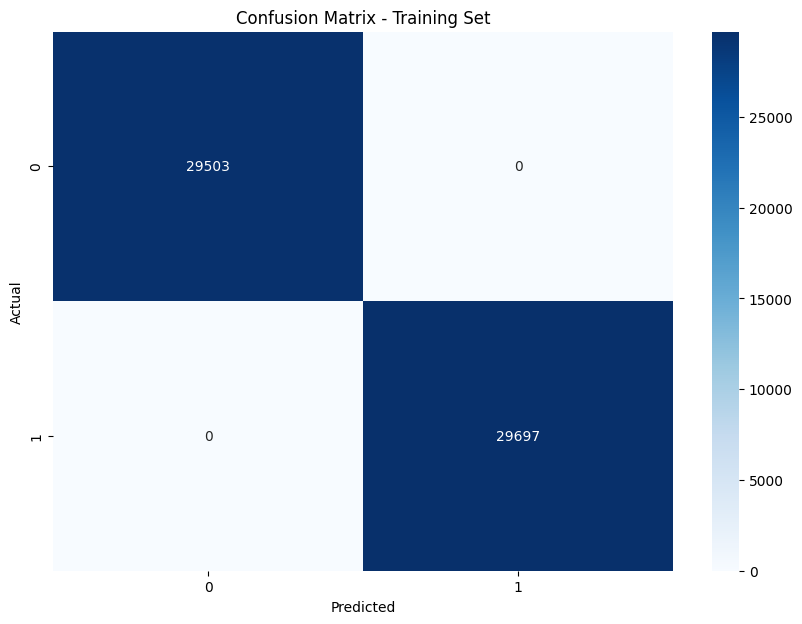

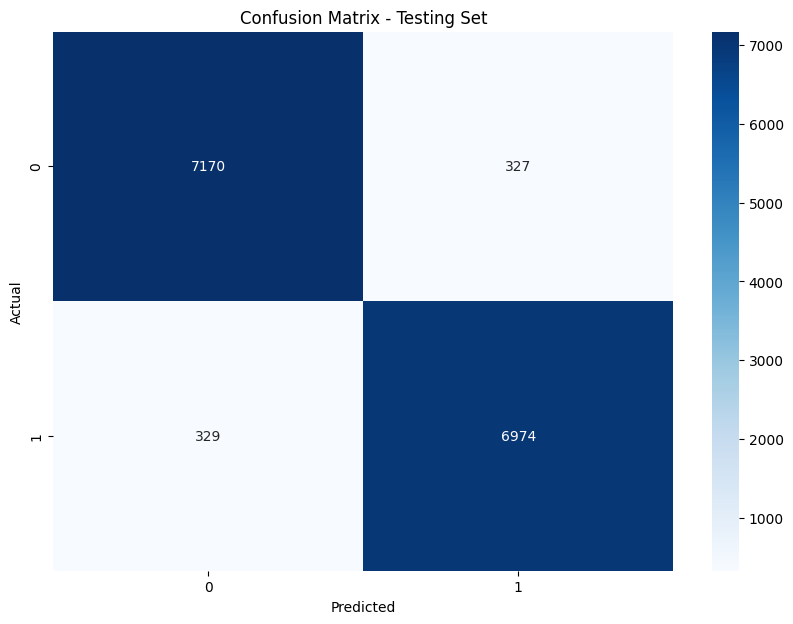

Classification Report - Training Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29503
           1       1.00      1.00      1.00     29697

    accuracy                           1.00     59200
   macro avg       1.00      1.00      1.00     59200
weighted avg       1.00      1.00      1.00     59200

Classification Report - Testing Set
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7497
           1       0.96      0.95      0.96      7303

    accuracy                           0.96     14800
   macro avg       0.96      0.96      0.96     14800
weighted avg       0.96      0.96      0.96     14800



In [36]:
evaluate_model(DT_model, X_train, y_train, X_test, y_test)